# Visualize epidemiological parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from os.path import join
from itertools import product

from scseirx.model_nursing_home import SEIRX_nursing_home # agent-based simulation
from scseirx import analysis_functions as af # custom analysis functions

In [2]:
contact_network_src = '../data/contact_networks'

In [3]:
N_steps = 100
verbosity = 0
seed = 11

G = nx.readwrite.gpickle.read_gpickle(\
            join(contact_network_src, 'interactions_single_quarter.bz2'))

model = SEIRX_nursing_home(G)

In [4]:
def weibull_two_param(shape, scale):
    '''
    A two-parameter Weibull distribution, based on numpy ramdon's single 
    parameter distribution. We use this distribution in the simulation to draw
    random epidemiological parameters for agents from the given distribution
    See https://numpy.org/doc/stable/reference/random/generated/numpy.random.weibull.html
    '''
    return scale * np.random.weibull(shape)

In [5]:
exposure_duration = []
time_until_symptoms = []
infection_duration = []

for i in range(10000):
    tmp_epi_params = {}
    # for each of the three epidemiological parameters, check if
    # the parameter is an integer (if yes, pass it directly to the
    # agent constructor), or if it is specified by the shape and 
    # scale parameters of a Weibull distribution. In the latter 
    # case, draw a new number for every agent from the distribution
    # NOTE: parameters drawn from the distribution are rounded to
    # the nearest integer
    while True:
        for param_name, param in model.epi_params.items():
            if isinstance(param, int):
                tmp_epi_params[param_name] = param

            else:
                tmp_epi_params[param_name] = \
                    round(weibull_two_param(param[0], param[1]))

        if tmp_epi_params['exposure_duration'] > 0 and \
           tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration'] and\
           tmp_epi_params['infection_duration'] > \
           tmp_epi_params['exposure_duration']:
           break
        else:
            model.param_rerolls += 1
            if verbosity > 1:
                print('pathological epi-param case found!')
                print(tmp_epi_params)
                
    exposure_duration.append(tmp_epi_params['exposure_duration'])
    time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
    infection_duration.append(tmp_epi_params['infection_duration'])

In [54]:
symptomatic_employees = []
symptomatic_residents = []
for i in range(10000):
    model = SEIRX_nursing_home(G)
    agents = model.schedule.agents
    se = [a for a in agents if a.symptomatic_course and a.type == 'employee']
    sr = [a for a in agents if a.symptomatic_course and a.type == 'resident']
    
    symptomatic_employees.append(len(se))
    symptomatic_residents.append(len(sr))
    
symptomatic_residents = np.asarray(symptomatic_residents) / 35 * 100
symptomatic_employees = np.asarray(symptomatic_employees) / 18 * 100

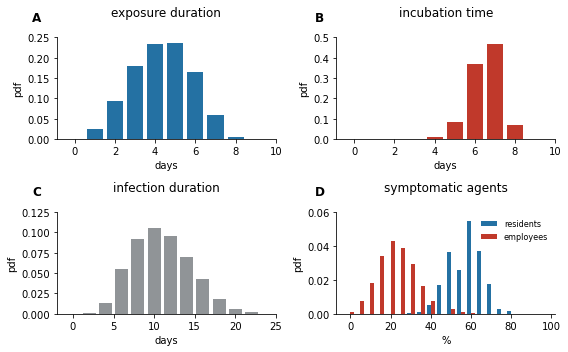

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
fig.subplots_adjust(wspace=0.3)
max_bins = [11, 11, 26]
steps = [1, 1, 2]
colors = ['#2471A3', '#C0392B', '#909497']
xticks = [range(0, 11, 2), range(0, 11, 2), range(0, 26, 5)]
labels = ['exposure duration\n', 'incubation time\n', 'infection duration\n']
ymaxes = [0.25, 0.5, 0.125]
statistics = [exposure_duration, time_until_symptoms, infection_duration]

for ax, max_bin, step, color, xtick, label, ymax, param in zip(axes.flatten(), 
    max_bins, steps, colors, xticks, labels, ymaxes, statistics):
    ax.hist(param, bins=range(0, max_bin, step), rwidth=0.8, color=color,
            density=True, align='left')
    ax.set_xticks(xtick)
    ax.set_title(label)
    ax.set_xlabel('days')
    ax.set_ylim(0, ymax)

# ratio of symptomatic cases
ax = axes[1, 1]
ax.hist([symptomatic_residents, symptomatic_employees],
            bins=range(0, 101, 5), density=True, color=['#2471A3', '#C0392B'],
            label=['residents', 'employees'], align='left')
ax.set_ylim(0, 0.06)
ax.set_title('symptomatic agents\n')
ax.set_xlabel('%')
ax.legend(fontsize=8, frameon=False)


for ax in axes.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('pdf')

fig.tight_layout()
fig.text(0.062, 0.93, 'A', fontsize=12, fontweight='bold')
fig.text(0.553, 0.93, 'B', fontsize=12, fontweight='bold')
fig.text(0.062, 0.445, 'C', fontsize=12, fontweight='bold')
fig.text(0.553, 0.445, 'D', fontsize=12, fontweight='bold')
plt.savefig('../plots/epi_param_distributions.pdf')
plt.savefig('../plots/epi_param_distributions.png', dpi=300)